**1. Import các thư viện cần thiết**

In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error as msle

**2. Đọc file dữ liệu và chia dataset theo tỉ lệ 9:1**

In [2]:
# Đọc file dữ liệu
df = pd.read_csv('D:\CTG.csv')

df = df[['Price','Low']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df1 = df
# Split the data into training, testing, and validation
train_size = int(0.9 * len(df))
test_size = int(0.1 * len(df))

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]


**Xem** **lại** **dataset**

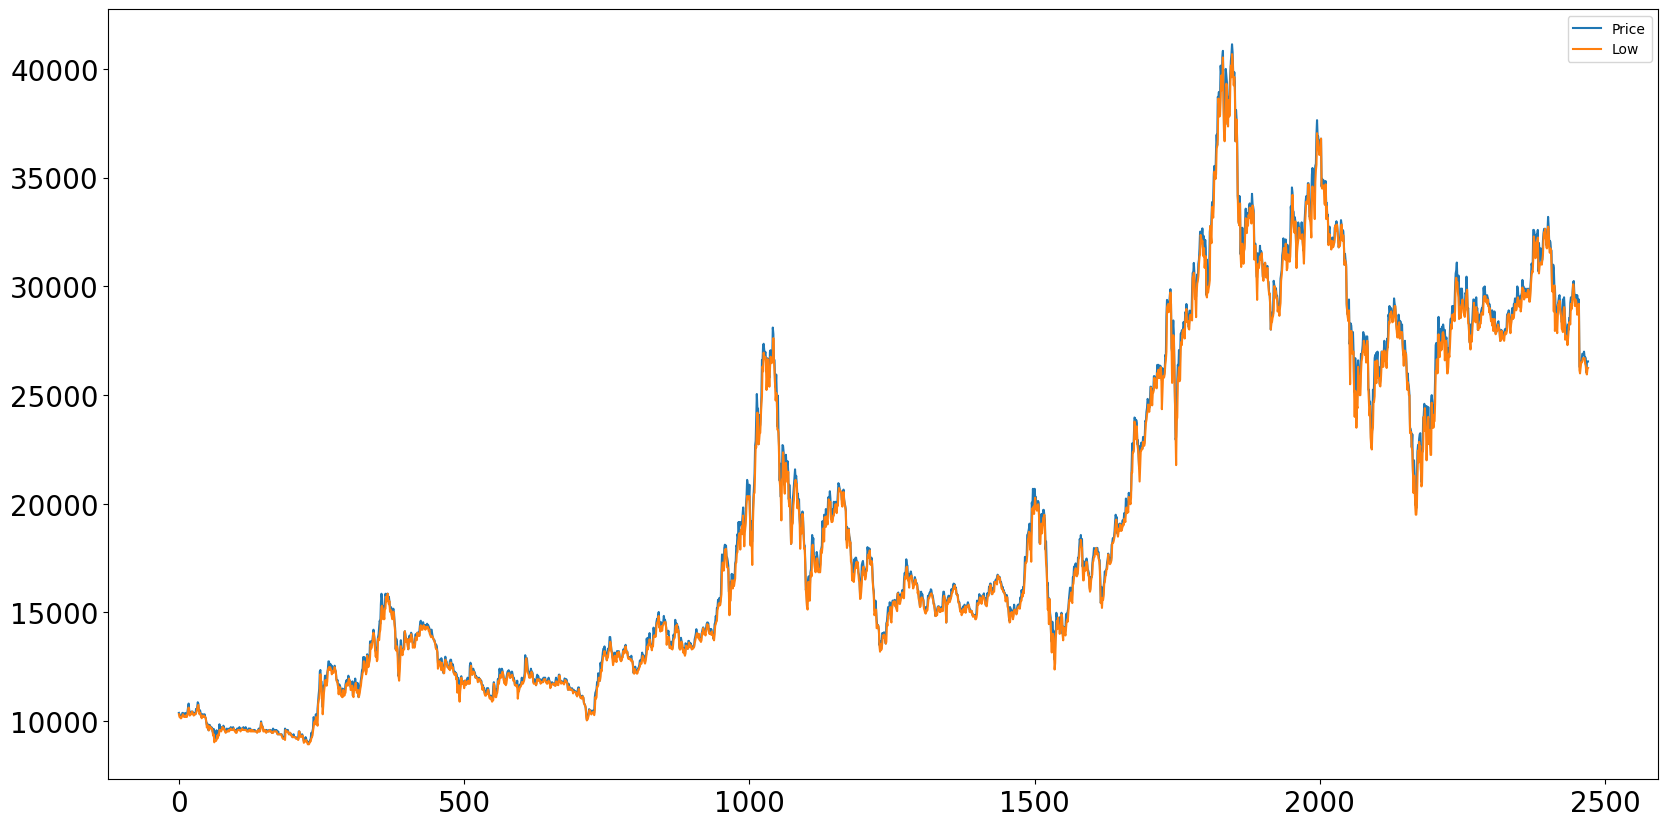

In [3]:
df.plot(figsize=(20, 10), fontsize=20)
plt.show()

***Tìm m thích hợp***

In [4]:
# Dùng adf để kiểm tra xem dataset có stationary hay chưa
from statsmodels.tsa.stattools import adfuller
adfuller(df['Price'])

(-1.4790235352046806,
 0.5438614038107454,
 1,
 2469,
 {'1%': -3.4330013210750745,
  '5%': -2.8627113331035243,
  '10%': -2.567393547066656},
 36992.4752760539)

In [5]:
# Vì dataset chưa stationary nên ta thực hiện diff()
df_diff = df1['Price'].diff().dropna()

In [6]:
# Tiếp tục dùng adf để kiểm tra xem p value có < 0.05 ko
adfuller(df_diff)

(-51.946172382469705,
 0.0,
 0,
 2469,
 {'1%': -3.4330013210750745,
  '5%': -2.8627113331035243,
  '10%': -2.567393547066656},
 36978.54167482712)

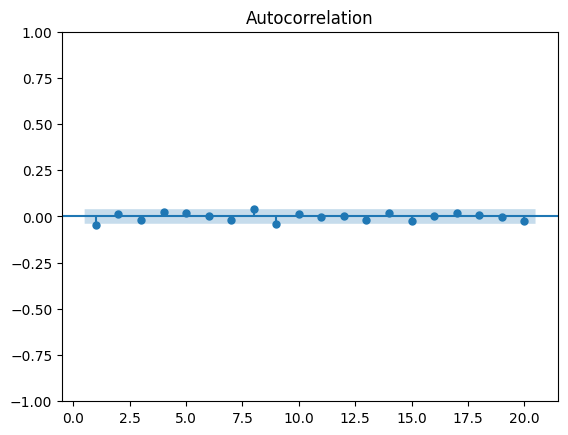

In [7]:
# Sau khi dataset đã stationary vẽ acf để tìm m
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_diff, lags = 20 , zero = False)
plt.show()

**3. Dùng auto_arima để tìm model thích hợp**

In [8]:
df

,Price,Low
0,10379.9,10318.5
1,10318.5,10195.6
2,10257.0,10195.6
3,10195.6,10134.2
4,10195.6,10134.2
...,...,...
2466,26700.0,26350.0
2467,26050.0,26050.0
2468,26500.0,25950.0
2469,26550.0,26200.0


In [9]:
# Tạo y_train, x_train
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])
# Dùng auto_arima để tìm thông số thích hợp
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = True, m =5)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=33589.836, Time=1.94 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=33591.716, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=33591.540, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=33591.610, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=33590.340, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=33589.149, Time=1.12 sec
 ARIMA(2,1,2)(0,0,0)[5] intercept   : AIC=33591.246, Time=0.61 sec
 ARIMA(2,1,2)(0,0,2)[5] intercept   : AIC=33591.071, Time=1.58 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=33589.207, Time=0.92 sec
 ARIMA(2,1,2)(1,0,2)[5] intercept   : AIC=inf, Time=2.32 sec
 ARIMA(1,1,2)(0,0,1)[5] intercept   : AIC=33595.524, Time=0.23 sec
 ARIMA(2,1,1)(0,0,1)[5] intercept   : AIC=33587.467, Time=0.64 sec
 ARIMA(2,1,1)(0,0,0)[5] intercept   : AIC=33594.805, Time=0.12 sec
 ARIMA(2,1,1)(1,0,1)[5] intercept   : AIC=33589.426, Time=1.00 sec
 ARIMA(2,1,1)(0,0,2)[5] i

**Dùng SARIMAX để train model**

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model1 = SARIMAX(y_train, exog = np.array(train_data['Price']), order=(1,1,1), seasonal_order=(0,0,1,5))
model_fit = model1.fit()

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**4. Quá trình test**

In [11]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
exg = np.array(test_data['Low'])
y_pred_test = model_fit.predict(start=len(y_train), end=len(y_test)+len(y_train)-1, exog=exg)
y_pred_test

array([26000., 26000., 26300., 26900., 26750., 27250., 27900., 28250.,
       28050., 28700., 28550., 28600., 28750., 28400., 28900., 30100.,
       30400., 30150., 30200., 29700., 29500., 28500., 28700., 29050.,
       28550., 29150., 29200., 29400., 29100., 28800., 28700., 28600.,
       28950., 29400., 29700., 29850., 28900., 28300., 28250., 27450.,
       27400., 27100., 27750., 27450., 27850., 28350., 28450., 29250.,
       28700., 28600., 28350., 29050., 28500., 28800., 28000., 28000.,
       28200., 28100., 28300., 28300., 28750., 28800., 28800., 28700.,
       29400., 29550., 29350., 29550., 29300., 29300., 29200., 29400.,
       29100., 29100., 28800., 29000., 28650., 28400., 28500., 28200.,
       28500., 27950., 28350., 28500., 28200., 27800., 27850., 28000.,
       27950., 28250., 28150., 28100., 27950., 27500., 27500., 27650.,
       27950., 27700., 27600., 27550., 27500., 27800., 27900., 27800.,
       27850., 28000., 28650., 28600., 28750., 28550., 28100., 27850.,
      

**6. Quá trình tạo index predict 30 ngày tiếp theo**

In [12]:
# Dùng thuật toán LR để tìm giá trị Low cho 30 ngày tiếp theo
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

ln_model.fit(np.array(train_data.index).reshape(-1,1), train_data['Low'])

last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Dự đoán giá trị low 30 ngày tiếp theo
low_next_30_days = ln_model.predict(x_next_30_days)

# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.predict(start=len(x_train), end = len(x_train)+ len(x_next_30_days)-1, exog=low_next_30_days)
# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[31049.88548767 31059.52162804 31069.1577684  31078.79390877
 31088.43004913 31098.06618949 31107.70232986 31117.33847022
 31126.97461059 31136.61075095 31146.24689131 31155.88303168
 31165.51917204 31175.1553124  31184.79145277 31194.42759313
 31204.0637335  31213.69987386 31223.33601422 31232.97215459
 31242.60829495 31252.24443531 31261.88057568 31271.51671604
 31281.15285641 31290.78899677 31300.42513713 31310.0612775
 31319.69741786 31329.33355823]


***7.Đánh giá độ chính xác thuật toán***

In [13]:
#MSLE
test_msle = msle(y_test, y_pred_test)
print('Testing MSLE:', test_msle)

#RMSE
test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))
print('Testing RMSE:', test_rmse)

#MAPE
test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print('Testing MAPE:', test_mape)

#MAE
test_mae = np.mean(np.abs(y_pred_test - y_test))
print('Testing MAE:', test_mae)

Testing MSLE: 0.00025199748176408545
Testing RMSE: 465.46741994294376
Testing MAPE: 1.1284858675277862
Testing MAE: 333.6032388663977


**8. Vẽ biểu đồ**

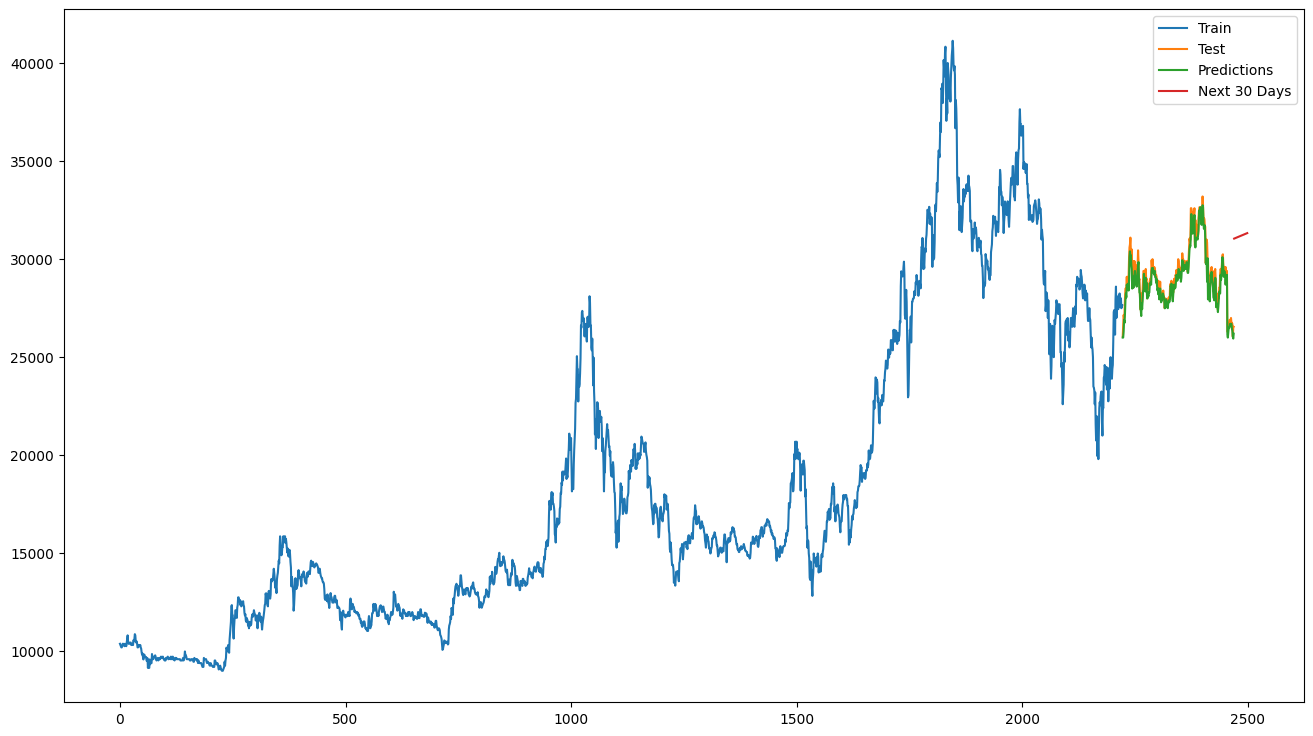

In [15]:
plt.figure(figsize=(16,9))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred_test)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next 30 Days'])
plt.show()